In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE
pd.set_option('display.max_columns', 100)

In [87]:
india_df = pd.read_csv('covid_19_india.csv')

## Preprocessing
* Convert date to datetime object
* Convert `-` values to `0` for unrecorded ConfirmedIndianNational & ConfirmedForeignNational
* Remove `*` from certain state names

In [88]:
print('Original dtypes')
india_df.dtypes

Original dtypes


Sno                          int64
Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [89]:
print('Checking for na values')
india_df.isna().any()

Checking for na values


Sno                         False
Date                        False
Time                        False
State/UnionTerritory        False
ConfirmedIndianNational     False
ConfirmedForeignNational    False
Cured                       False
Deaths                      False
Confirmed                   False
dtype: bool

In [90]:
india_df['Date'] = pd.to_datetime(india_df['Date'], format='%Y-%m-%d')
india_df['ConfirmedIndianNational'] = india_df['ConfirmedIndianNational'].apply(lambda x: 0 if x == '-' else int(x))
india_df['ConfirmedForeignNational'] = india_df['ConfirmedForeignNational'].apply(lambda x: 0 if x == '-' else int(x))
india_df['State/UnionTerritory'] = india_df['State/UnionTerritory'].apply(lambda x: x[:x.find('*')] if x.find('*') != -1 else x)

## 1.1

In [91]:
print('Modified dtypes w/ column names')
india_df.dtypes

Modified dtypes w/ column names


Sno                                  int64
Date                        datetime64[ns]
Time                                object
State/UnionTerritory                object
ConfirmedIndianNational              int64
ConfirmedForeignNational             int64
Cured                                int64
Deaths                               int64
Confirmed                            int64
dtype: object

In [92]:
print('Unique values/ranges for categorical values')
print('Unique states')
print(india_df['State/UnionTerritory'].unique())
print('Unique time values')
print(india_df['Time'].unique())
print('Date range')
print(india_df['Date'].min(), 'to', india_df['Date'].max())

Unique values/ranges for categorical values
Unique states
['Kerala' 'Telengana' 'Delhi' 'Rajasthan' 'Uttar Pradesh' 'Haryana'
 'Ladakh' 'Tamil Nadu' 'Karnataka' 'Maharashtra' 'Punjab'
 'Jammu and Kashmir' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chhattisgarh' 'Chandigarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram'
 'Andaman and Nicobar Islands' 'Goa' 'Unassigned' 'Assam' 'Jharkhand'
 'Arunachal Pradesh' 'Tripura' 'Nagaland' 'Meghalaya'
 'Dadra and Nagar Haveli and Daman and Diu'
 'Cases being reassigned to states' 'Sikkim' 'Daman & Diu' 'Lakshadweep'
 'Telangana' 'Dadra and Nagar Haveli' 'Himanchal Pradesh' 'Karanataka']
Unique time values
['6:00 PM' '10:00 AM' '7:30 PM' '9:30 PM' '8:30 PM' '5:00 PM' '8:00 AM']
Date range
2020-01-30 00:00:00 to 2021-08-11 00:00:00


In [93]:
print('Ranges for numerical/continuous columns')
india_df.describe().loc[['min', 'max']]

Ranges for numerical/continuous columns


,Sno,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
min,1.0,0.0,0.0,0.0,0.0,0.0
max,18110.0,177.0,14.0,6159676.0,134201.0,6363442.0


## 1.2
* Grouping data month wise and plotting Cured/Deaths/Confirmed.

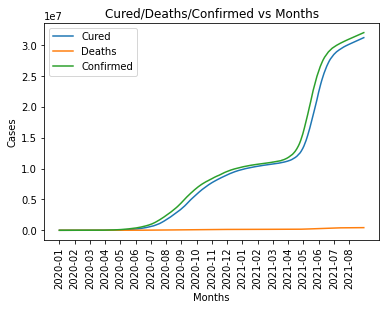

In [94]:
# group by months for x ticks
month_criteria = india_df['Date'].dt.to_period('M')
x_months = list(map(str, month_criteria.unique()))

# group by date, to show total at each date
date_criteria = india_df['Date'].dt.to_period('D')
date_grouped_df = india_df.groupby(date_criteria)[['Cured', 'Deaths', 'Confirmed']].sum()
dates = list(map(str, date_grouped_df.index))

# calculate spacing for x ticks
x_months_spacing = (np.arange(len(x_months)) * len(dates)) / len(x_months)

plt.plot(dates, date_grouped_df.Cured, label='Cured')
plt.plot(dates, date_grouped_df.Deaths, label='Deaths')
plt.plot(dates, date_grouped_df.Confirmed, label='Confirmed')

plt.xticks(x_months_spacing, x_months, rotation=90)
plt.xlabel('Months')
plt.ylabel('Cases')
plt.title('Cured/Deaths/Confirmed vs Months')
plt.legend()
plt.show()

## 1.3
### Preprocessing
* We check value counts for null, as `Sputnik V` has a lot of nulls while `Covishield` and `Covaxin` have lot less nulls, we drop na rows for the latter two (with minimal loss of information), while preserve na for the former by replacing them with min.

In [95]:
vaccine_df = pd.read_csv('covid_vaccine_statewise.csv')

In [96]:
vaccine_df.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),Sputnik V (Doses Administered),AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23757.0,24517.0,2.0,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27348.0,31252.0,4.0,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41361.0,58083.0,5.0,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81901.0,113613.0,11.0,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98111.0,153145.0,24.0,251280.0


In [97]:
print('Original dtypes')
vaccine_df.dtypes

Original dtypes


Updated On                              object
State                                   object
Total Doses Administered               float64
Sessions                               float64
 Sites                                 float64
First Dose Administered                float64
Second Dose Administered               float64
Male (Doses Administered)              float64
Female (Doses Administered)            float64
Transgender (Doses Administered)       float64
 Covaxin (Doses Administered)          float64
CoviShield (Doses Administered)        float64
Sputnik V (Doses Administered)         float64
AEFI                                   float64
18-44 Years (Doses Administered)       float64
45-60 Years (Doses Administered)       float64
60+ Years (Doses Administered)         float64
18-44 Years(Individuals Vaccinated)    float64
45-60 Years(Individuals Vaccinated)    float64
60+ Years(Individuals Vaccinated)      float64
Male(Individuals Vaccinated)           float64
Female(Indivi

In [98]:
print('Checking states')
vaccine_df['State'].unique()

Checking states


array(['India', 'Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype=object)

In [99]:
print('Checking na columns')
vaccine_df.isna().any()

Checking na columns


Updated On                             False
State                                  False
Total Doses Administered                True
Sessions                                True
 Sites                                  True
First Dose Administered                 True
Second Dose Administered                True
Male (Doses Administered)               True
Female (Doses Administered)             True
Transgender (Doses Administered)        True
 Covaxin (Doses Administered)           True
CoviShield (Doses Administered)         True
Sputnik V (Doses Administered)          True
AEFI                                    True
18-44 Years (Doses Administered)        True
45-60 Years (Doses Administered)        True
60+ Years (Doses Administered)          True
18-44 Years(Individuals Vaccinated)     True
45-60 Years(Individuals Vaccinated)     True
60+ Years(Individuals Vaccinated)       True
Male(Individuals Vaccinated)            True
Female(Individuals Vaccinated)          True
Transgende

In [100]:
# change date dtype
vaccine_df['Updated On'] = pd.to_datetime(vaccine_df['Updated On'], format='%d/%m/%Y')
print('Updated On: Date range')
print(vaccine_df['Updated On'].min(), 'to', vaccine_df['Updated On'].max())

Updated On: Date range
2021-01-16 00:00:00 to 2021-08-16 00:00:00


In [101]:
print('Modified dtypes w/ column names')
vaccine_df.dtypes

Modified dtypes w/ column names


Updated On                             datetime64[ns]
State                                          object
Total Doses Administered                      float64
Sessions                                      float64
 Sites                                        float64
First Dose Administered                       float64
Second Dose Administered                      float64
Male (Doses Administered)                     float64
Female (Doses Administered)                   float64
Transgender (Doses Administered)              float64
 Covaxin (Doses Administered)                 float64
CoviShield (Doses Administered)               float64
Sputnik V (Doses Administered)                float64
AEFI                                          float64
18-44 Years (Doses Administered)              float64
45-60 Years (Doses Administered)              float64
60+ Years (Doses Administered)                float64
18-44 Years(Individuals Vaccinated)           float64
45-60 Years(Individuals Vacc

In [102]:
vaccine_df.describe()

,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),Sputnik V (Doses Administered),AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
count,7.621000e+03,7.621000e+03,7621.000000,7.621000e+03,7.621000e+03,7.461000e+03,7.461000e+03,7461.000000,7.621000e+03,7.621000e+03,2995.000000,5438.000000,1.702000e+03,1.702000e+03,1.702000e+03,3.733000e+03,3.734000e+03,3.734000e+03,1.600000e+02,1.600000e+02,160.000000,5.919000e+03
mean,9.188171e+06,4.792358e+05,2282.872064,7.414415e+06,1.773755e+06,3.620156e+06,3.168416e+06,1162.978019,1.044669e+06,8.126553e+06,9655.570618,1139.402538,8.773958e+06,7.442161e+06,5.641605e+06,1.395895e+06,2.916515e+06,2.627444e+06,4.461687e+07,3.951018e+07,12370.543750,4.547842e+06
std,3.746180e+07,1.911511e+06,7275.973730,2.995209e+07,7.570382e+06,1.737938e+07,1.515310e+07,5931.353995,4.452259e+06,3.298414e+07,43882.536177,3454.608046,2.660829e+07,2.225999e+07,1.681650e+07,5.501454e+06,9.567607e+06,8.192225e+06,3.950749e+07,3.417684e+07,12485.026753,1.834182e+07
min,7.000000e+00,0.000000e+00,0.000000,7.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,7.000000e+00,0.000000,0.000000,2.662400e+04,1.681500e+04,9.994000e+03,1.059000e+03,1.136000e+03,5.580000e+02,2.375700e+04,2.451700e+04,2.000000,7.000000e+00
25%,1.356570e+05,6.004000e+03,69.000000,1.166320e+05,1.283100e+04,5.655500e+04,5.210700e+04,8.000000,0.000000e+00,1.331340e+05,0.000000,109.250000,4.344842e+05,2.326275e+05,1.285605e+05,5.655400e+04,9.248225e+04,5.615975e+04,5.739350e+06,5.023407e+06,1278.750000,7.427550e+04
50%,8.182020e+05,4.547000e+04,597.000000,6.614590e+05,1.388180e+05,3.897850e+05,3.342380e+05,113.000000,1.185100e+04,7.567360e+05,0.000000,294.000000,3.095970e+06,2.695938e+06,1.805696e+06,2.947270e+05,8.330395e+05,7.887425e+05,3.716590e+07,3.365402e+07,8007.500000,4.022880e+05
75%,6.625243e+06,3.428690e+05,1708.000000,5.387805e+06,1.166434e+06,2.735777e+06,2.561513e+06,800.000000,7.579300e+05,6.007817e+06,2519.000000,808.000000,7.366241e+06,6.969726e+06,5.294763e+06,9.105160e+05,2.499280e+06,2.337874e+06,7.441663e+07,6.685368e+07,19851.000000,3.501562e+06
max,5.132284e+08,3.501031e+07,73933.000000,4.001504e+08,1.130780e+08,2.701636e+08,2.395186e+08,98275.000000,6.236742e+07,4.468251e+08,588039.000000,26542.000000,2.243304e+08,1.667575e+08,1.186927e+08,9.224315e+07,9.096888e+07,6.731098e+07,1.349420e+08,1.156684e+08,46462.000000,2.506569e+08


In [103]:
vaccine_states = ['Kerala', 'Delhi', 'Rajasthan', 'Haryana', 'Uttar Pradesh', 'Tamil Nadu']
vaccine_doses = ['Sputnik V (Doses Administered)', ' Covaxin (Doses Administered)', 'CoviShield (Doses Administered)']

In [104]:
vaccine_df.describe()[vaccine_doses]

,Sputnik V (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered)
count,2995.000000,7.621000e+03,7.621000e+03
mean,9655.570618,1.044669e+06,8.126553e+06
std,43882.536177,4.452259e+06,3.298414e+07
min,0.000000,0.000000e+00,7.000000e+00
25%,0.000000,0.000000e+00,1.331340e+05
50%,0.000000,1.185100e+04,7.567360e+05
75%,2519.000000,7.579300e+05,6.007817e+06
max,588039.000000,6.236742e+07,4.468251e+08


In [105]:
# checking concentration of nulls
print(vaccine_df['CoviShield (Doses Administered)'].isnull().value_counts())
print(vaccine_df[' Covaxin (Doses Administered)'].isnull().value_counts())
print(vaccine_df['Sputnik V (Doses Administered)'].isnull().value_counts())

False    7621
True      224
Name: CoviShield (Doses Administered), dtype: int64
False    7621
True      224
Name:  Covaxin (Doses Administered), dtype: int64
True     4850
False    2995
Name: Sputnik V (Doses Administered), dtype: int64


In [106]:
# drop 
vaccine_df.dropna(subset=[' Covaxin (Doses Administered)', 'CoviShield (Doses Administered)'], inplace=True)

In [107]:
# replace na 
vaccine_df['Sputnik V (Doses Administered)'].fillna(vaccine_df['Sputnik V (Doses Administered)'].min(), inplace=True)

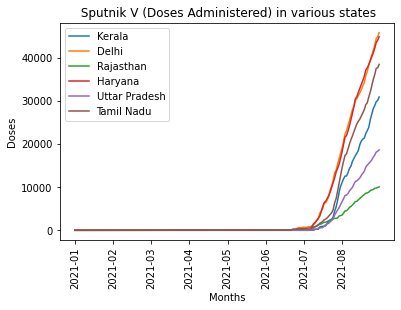

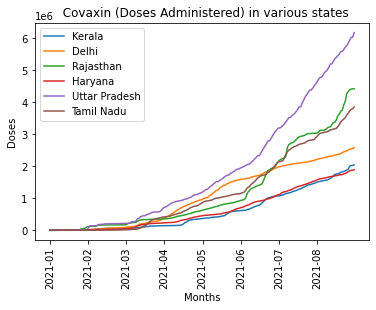

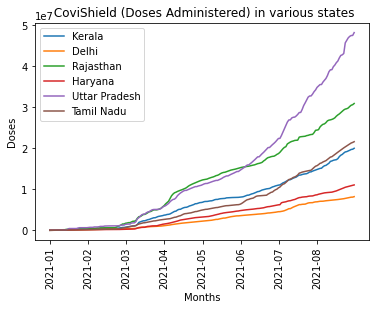

In [108]:
# Plotting (Vaccinewise)
get_str_list = lambda x: list(map(str, x))
day_criteria_vaccine_wise = vaccine_df['Updated On'].dt.to_period('D')
days_vaccine_wise = day_criteria_vaccine_wise.unique()
months_vaccine_wise = get_str_list(vaccine_df['Updated On'].dt.to_period('M').unique())
x_months_vaccine_wise_spacing = (np.arange(len(months_vaccine_wise)) * len(days_vaccine_wise)) / len(months_vaccine_wise)
for vaccine in vaccine_doses:
    totals = {}
    for state in vaccine_states:
        df_here = vaccine_df[vaccine_df['State'] == state][['Updated On', vaccine]]
        df_here_grouped = df_here.groupby(df_here['Updated On'].dt.to_period('D'))[vaccine].sum()
        for day in days_vaccine_wise:
            if day not in df_here_grouped.index:
                df_here_grouped[day] = 0
        assert (get_str_list(days_vaccine_wise) == get_str_list(df_here_grouped.index))
        totals[state] = list(df_here_grouped)
    for state in totals:
        plt.plot(get_str_list(days_vaccine_wise), totals[state], label=state)
    plt.title(f' {vaccine} in various states')
    plt.xticks(x_months_vaccine_wise_spacing, months_vaccine_wise, rotation=90)
    plt.xlabel('Months')
    plt.ylabel('Doses')
    plt.legend()
    plt.show()

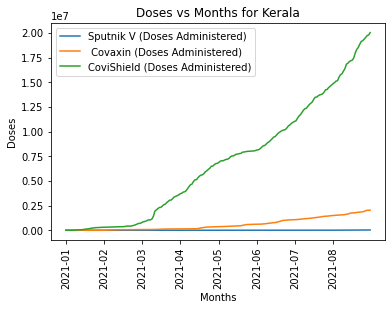

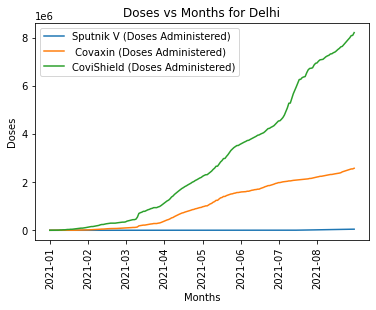

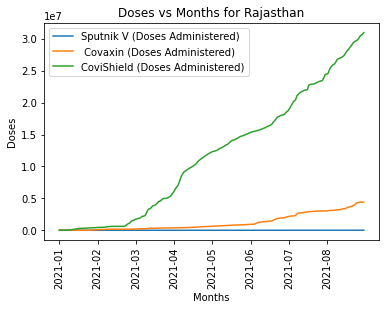

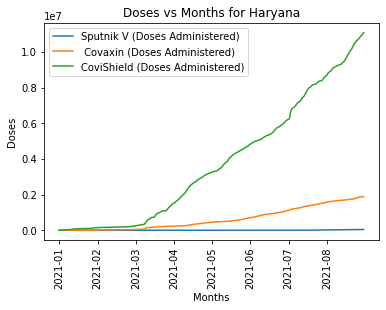

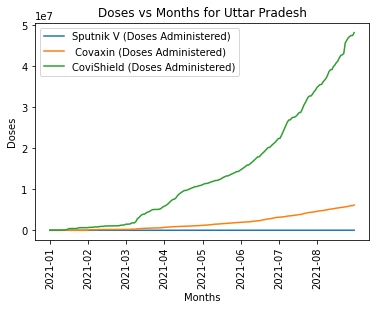

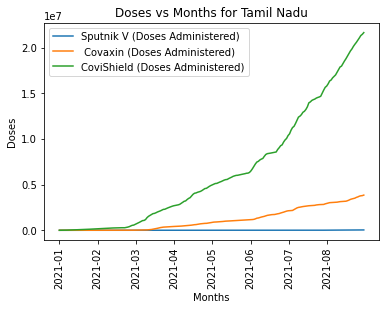

In [109]:
# Plotting (Statewise)
for state in vaccine_states:
    sub_df = vaccine_df[vaccine_df['State'] == state][['Updated On'] + vaccine_doses]
    month_criteria_sub_df = sub_df['Updated On'].dt.to_period('M')
    x_months_sub_df = list(map(str, month_criteria_sub_df.unique()))

    date_criteria_sub_df = sub_df['Updated On'].dt.to_period('D')
    date_grouped_sub_df = sub_df.groupby(date_criteria_sub_df)[vaccine_doses].sum()
    dates_sub_df = list(map(str, date_criteria_sub_df.index))

    x_months_spacing_sub_df = (np.arange(len(x_months_sub_df)) * len(dates_sub_df)) / len(x_months_sub_df)
    
    for dose in vaccine_doses:
        plt.plot(dates_sub_df, date_grouped_sub_df[dose], label=dose)
    
    plt.xticks(x_months_spacing_sub_df, x_months_sub_df, rotation=90)
    plt.xlabel('Months')
    plt.ylabel('Doses')
    plt.title('Doses vs Months for ' + state)
    plt.legend()
    plt.show()


## 1.4.a

In [110]:
MASK_SAMPLES = 500
MASK_PATH = 'Mask Dataset'

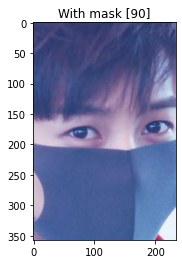

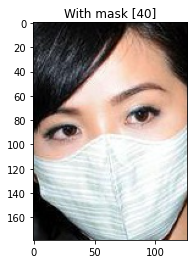

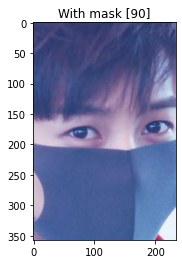

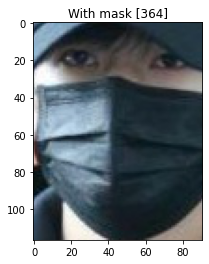

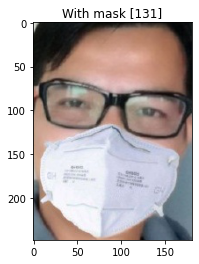

In [111]:
# visualising with mask
for _ in range(5):
    idx = np.random.randint(1, MASK_SAMPLES)
    img = mpimg.imread(f'{MASK_PATH}/with_mask/with_mask_{idx}.jpg')
    plt.figure()
    plt.title(f'With mask [{idx}]')
    plt.imshow(img)


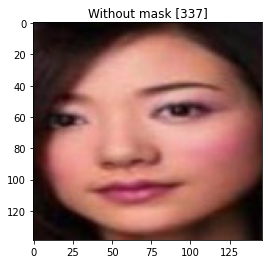

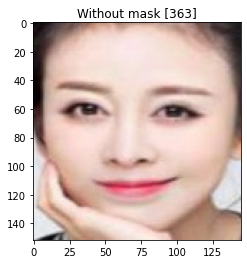

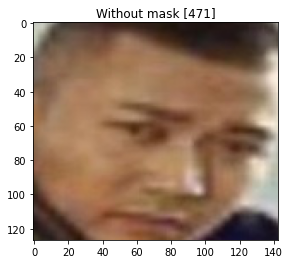

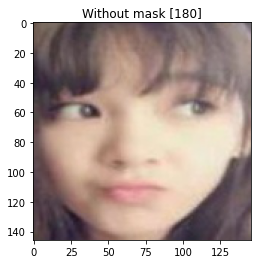

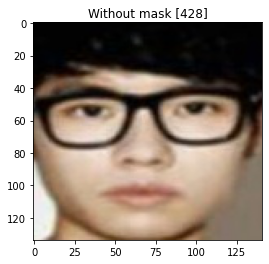

In [112]:
# visualising without mask
for _ in range(5):
    idx = np.random.randint(1, MASK_SAMPLES)
    img = mpimg.imread(f'{MASK_PATH}/without_mask/without_mask_{idx}.jpg')
    plt.figure()
    plt.title(f'Without mask [{idx}]')
    plt.imshow(img)

## 1.4.b
* Compressing images to avoid larger arrays on flattenning

In [113]:
X = []
Y = []
size_img = (128, 128)
for i in range(MASK_SAMPLES):
    img_m = Image.open(f'{MASK_PATH}/with_mask/with_mask_{i + 1}.jpg')
    img_wm = Image.open(f'{MASK_PATH}/without_mask/without_mask_{i + 1}.jpg')
    img_m = img_m.resize(size_img, Image.ANTIALIAS)
    img_wm = img_wm.resize(size_img, Image.ANTIALIAS)
    X.append(list(np.array(img_m).flatten()))
    Y.append(1)
    X.append(list(np.array(img_wm).flatten()))
    Y.append(0)
O = np.arange(0, len(X))
np.random.shuffle(O)
X_shuffled = np.array([X[o] for o in O])
Y_shuffled = np.array([Y[o] for o in O])

In [114]:
X_embedded = TSNE(n_components=2).fit_transform(X_shuffled)
X_shuffled.shape, X_embedded.shape

((1000, 49152), (1000, 2))

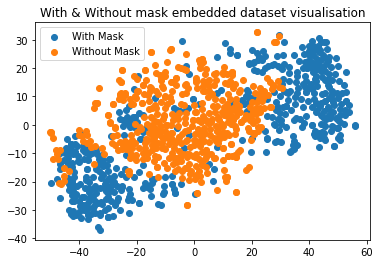

In [115]:
Y_mask = np.where(Y_shuffled == 1)
Y_wmask = np.where(Y_shuffled == 0)
plt.scatter(X_embedded[Y_mask][:, 0], X_embedded[Y_mask][:, 1], label='With Mask')
plt.scatter(X_embedded[Y_wmask][:, 0], X_embedded[Y_wmask][:, 1], label='Without Mask')
plt.legend()
plt.title('With & Without mask embedded dataset visualisation')
plt.show()